## **Identification de langue avec la tokenisation BERT ou Tiktoken**

In [1]:
import pandas as pd
import random
import joblib
from sklearn.metrics import accuracy_score, classification_report

# Choix de la Tokenisation (False = BERT, True Tiktoken)
titoken_tokenization = True

## Pour résoudre les problème de mémoire et de performances
nb_token_max = 2000
nb_phrase_lang = 56000

import warnings
warnings.filterwarnings('ignore')

#### Lectures des phrases et de leur étiquette "Langue" pour les langues sélectionnées

In [2]:
# Ouvrir le fichier d'entrée en mode lecture
def create_lang_df(path):
    df = pd.read_csv(path, index_col ='id')
    return df

df_big = create_lang_df('../data/multilingue/sentences.csv')
lan_code = ['eng','fra','deu','spa','ita']
df = pd.DataFrame(columns=df_big.columns)
for i in range(len(lan_code)):
    df= pd.concat([df, df_big[df_big['lan_code']==lan_code[i]].iloc[:nb_phrase_lang]])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
n_rows = len(df)
print('Nombre de lignes de sentence.csv:',n_rows)
df

Nombre de lignes de sentence.csv: 280000


,lan_code,sentence
0,spa,"Figaro nos invitó a su boda, pero cuando llega..."
1,ita,Ho bisogno di parlarti stanotte.
2,deu,John arbeitet im Bereich Neuromarketing.
3,spa,Tú irás a la escuela.
4,deu,"Warum denkt jeder, ich sei dumm?"
...,...,...
279995,deu,Ich weiß absolut gar nichts darüber.
279996,ita,Marie ha capito.
279997,deu,"Um Missverständnisse zu vermeiden, hat er den ..."
279998,deu,Tom hatte seit Jahren kein Schwimmbad mehr von...


#### Réalisation d'un jeu de données d'entrainement et de test

In [3]:
# créer 2 dataframes: 1 train (50% des phrases) et 1 test (50% des phrases)
n_train = int(n_rows*0.5)
df_train = df.iloc[:n_train].sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df.iloc[n_train:].sample(frac=1, random_state=24).reset_index(drop=True)
pd.set_option('display.max_colwidth', 150)
display(df_train)
nb_phrases_lang =[]
for l in lan_code:
    nb_phrases_lang.append(sum(df_train['lan_code']==l))
nb_phrases_lang

,lan_code,sentence
0,deu,Sie sagte: „Auf Wiedersehen!“
1,spa,Me lo he jugado el todo por el todo.
2,spa,Me pregunto si Tom y Mary están locos.
3,eng,I've lived here my whole life.
4,ita,Pensate che Mary sia troppo grassa per essere una cheerleader?
...,...,...
139995,deu,"„Das darf ich nicht verraten!“ – „Was würde passieren, wenn du’s doch tätest?“"
139996,ita,Ken è andato al supermercato a comprare delle uova.
139997,fra,"Si ton frère te dit : je suis pauvre, et j'ai froid, / Ton devoir est d'offrir la moitié de ton toit / À ton frère."
139998,deu,"Wir beabsichtigen mit allen Ländern, die uns umgeben, friedlich zusammenzuarbeiten."


[27860, 27929, 28006, 27986, 28219]

#### Selection du tokenizer

In [4]:
# Selection du tokenizer
if titoken_tokenization:
    import tiktoken
    tokenizer = tiktoken.get_encoding("cl100k_base")
else:
    from transformers import BertTokenizerFast
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-multilingual-uncased')

#### Tokenisation des données sélectionnées

In [5]:
from collections import Counter
import pickle

def save_dict_token(dict_ids):
    with open('../data/dict_token', 'wb') as fichier:
        pickle.dump(dict_ids, fichier)

def load_dict_token():
    with open('../data/dict_token', 'rb') as fichier:
        dict_ids = pickle.load(fichier)
        # Définition d'une liste 'écrite' des tokens
        decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
    return dict_ids, decoded_keys

# Création d'un dictionnaire de complet des Token ID à partir des phrases selectionnée
dict_ids = Counter(token for ligne in df['sentence'] for token in tokenizer.encode(ligne))

# Tri des token en fonction de leur fréquence
dict_ids= sorted(dict_ids.items(), key=lambda x: x[1], reverse=True) 
print("Nombre de tokens avant plafonnement:",len(dict_ids))
print("Nombre de tokens après plafonnement:",min(len(dict_ids),nb_token_max))

# Limitation du nombre de token
dict_ids = dict(dict_ids[:nb_token_max])
# save_dict_token(dict_ids)

# Définition d'une liste 'écrite' des tokens
decoded_keys = [tokenizer.decode([key]) for key in list(dict_ids.keys())]
print("Liste des 50 tokens les plus fréquents:",decoded_keys[:50])

Nombre de tokens avant plafonnement: 33588
Nombre de tokens après plafonnement: 2000
Liste des 50 tokens les plus fréquents: ['.', ',', '?', ' a', ' de', ' la', ' que', 'Tom', ' un', ' the', ' in', ' to', 'I', "'", 'i', ' le', ' en', ' es', 'é', ' l', '!', 'o', ' ist', ' pas', ' Tom', ' me', 'Ich', ' di', ' is', 'Je', ' nicht', ' you', ' die', ' el', ' à', ' est', 'en', 'a', ' ne', ' è', ' d', ' se', ' no', ' una', ' zu', '¿', ' of', 'Il', ' du', "'t"]


#### Création d'un Bag Of Worlds

In [6]:
import numpy as np

# Créez un DataFrame BOW avec les phrases (lignes) et les fréquences de chaque token (colonnes)
def create_BOW(data):
    BOW = []
    for ligne in data:
        l_tokenised = tokenizer.encode(ligne)
        BOW.append([l_tokenised.count(token) for token in dict_ids])
    return BOW

In [7]:
X_train = create_BOW(df_train['sentence'])
y_train = df_train['lan_code'].values.tolist() 

In [8]:
X_test = create_BOW(df_test['sentence'])
y_test = df_test['lan_code'].values.tolist()

#### Choix du nom du fichier de sauvegarde du classifieur

In [9]:
def get_file_name(titoken_tokenization, classifier):
    if titoken_tokenization:
        return "id_lang_tiktoken_"+classifier+".pkl"
    else:
        return "id_lang_BERT_"+classifier+".pkl"

#### Création d'un classificateur avec l'algorithme Naïve Bayes

In [32]:
from sklearn import svm
from sklearn import naive_bayes

# On entraine et on prédit:
# clf_nb = naive_bayes.MultinomialNB()  # BernoulliNB() # MultinomialNB() 
# clf_nb.fit(X_train, y_train)

# Save the model to a file
# joblib.dump(clf_nb, "../data/"+get_file_name(titoken_tokenization,"nb"))

['../data/id_lang_tiktoken_nb.pkl']

In [10]:
# Load the model from a file
clf_nb = joblib.load("../data/"+get_file_name(titoken_tokenization,"nb"))
dict_ids, decoded_keys = load_dict_token()

y_pred_nb = clf_nb.predict(X_test)
accuracy_naive_bayes = accuracy_score(y_test, y_pred_nb)
display(pd.crosstab(y_test,y_pred_nb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Naïve Bayes = {:.3f}".format(accuracy_naive_bayes))

Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,27944,11,9,20,10
eng,50,27947,21,70,52
fra,14,9,27835,86,127
ita,21,10,53,27486,211
spa,29,31,104,192,27658


Accuracy Naïve Bayes = 0.992


#### Création d'un classificateur avec l'algorithme Gradiant Boosting
> Attention le training de cet algorithme peut être très long<br>
> Il peut être interessant de charger le modèle entrainé (si vous l'avez sauvez préalablement)

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Créer un classificateur clf et entraîner le modèle sur l'ensemble d'entraînement
# clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=1, random_state=0).fit(X_train, y_train)

# Save the model to a file
#joblib.dump(clf_gb, "../data/"+get_file_name(titoken_tokenization,"gb"))

['../data/id_lang_tiktoken_gb.pkl']

In [11]:
# Load the model from a file
clf_gb = joblib.load("../data/"+get_file_name(titoken_tokenization,"gb"))
# dict_ids, decoded_keys = load_dict_token()

# Calculer les prédictions 
y_pred_gb = clf_gb.predict(X_test)
accuracy_gradiant_boosting = accuracy_score(y_test, y_pred_gb)
display(pd.crosstab(y_test,y_pred_gb,rownames=['Classe réelle'], colnames=['Classe prédite']))
print("Accuracy Gradiant Boosting = {:.3f}".format(accuracy_gradiant_boosting))

Classe prédite,deu,eng,fra,ita,spa
Classe réelle,,,,,
deu,27341,163,79,149,262
eng,67,27697,13,58,305
fra,31,53,27212,298,477
ita,160,107,177,26662,675
spa,63,95,225,474,27157


Accuracy Gradiant Boosting = 0.972


#### Exemples d'utilisation

In [12]:
# Instanciation d'un exemple
exemple = ["france is often snowy during spring , and it is relaxing in january .",
           "elle adore les voitures très luxueuses, et toi ?",
           "she loves very luxurious cars, don't you?",
           "vamos a la playa",
           "Ich heiße Keyne, und das ist wunderbar",
           "she loves you, mais elle te hait aussi, and das ist traurig", # Attention à cette phrase trilingue
           "I ate caviar.", 
           "Vogliamo visitare il Colosseo e nuotare nel Tevere."
          ]


# Prédiction des classes de l'exemple par le classifieur Naive Bayes
predictions_nb = clf_nb.predict(create_BOW(exemple))

# Prédiction des classes de l'exemple par le classifieur Gradiant Boosting
predictions_gb = clf_gb.predict(create_BOW(exemple))

# Affichage des prédictions
print('Langue réelle                 :',['eng','fra','eng','spa','deu','en,fr,de','en','ita'])
print('Prédictions Naive Bayes       :',predictions_nb)
print('Prédictions Gradiant Boosting :',predictions_gb)

Langue réelle                 : ['eng', 'fra', 'eng', 'spa', 'deu', 'en,fr,de', 'en', 'ita']
Prédictions Naive Bayes       : ['eng' 'fra' 'eng' 'spa' 'deu' 'fra' 'ita' 'ita']
Prédictions Gradiant Boosting : ['eng' 'fra' 'eng' 'spa' 'deu' 'deu' 'eng' 'ita']


#### **Analyse en Composante Principale pour visualiser l'importance des tokens**
#### dans la détection de langue par le classifieur Naive Bayes

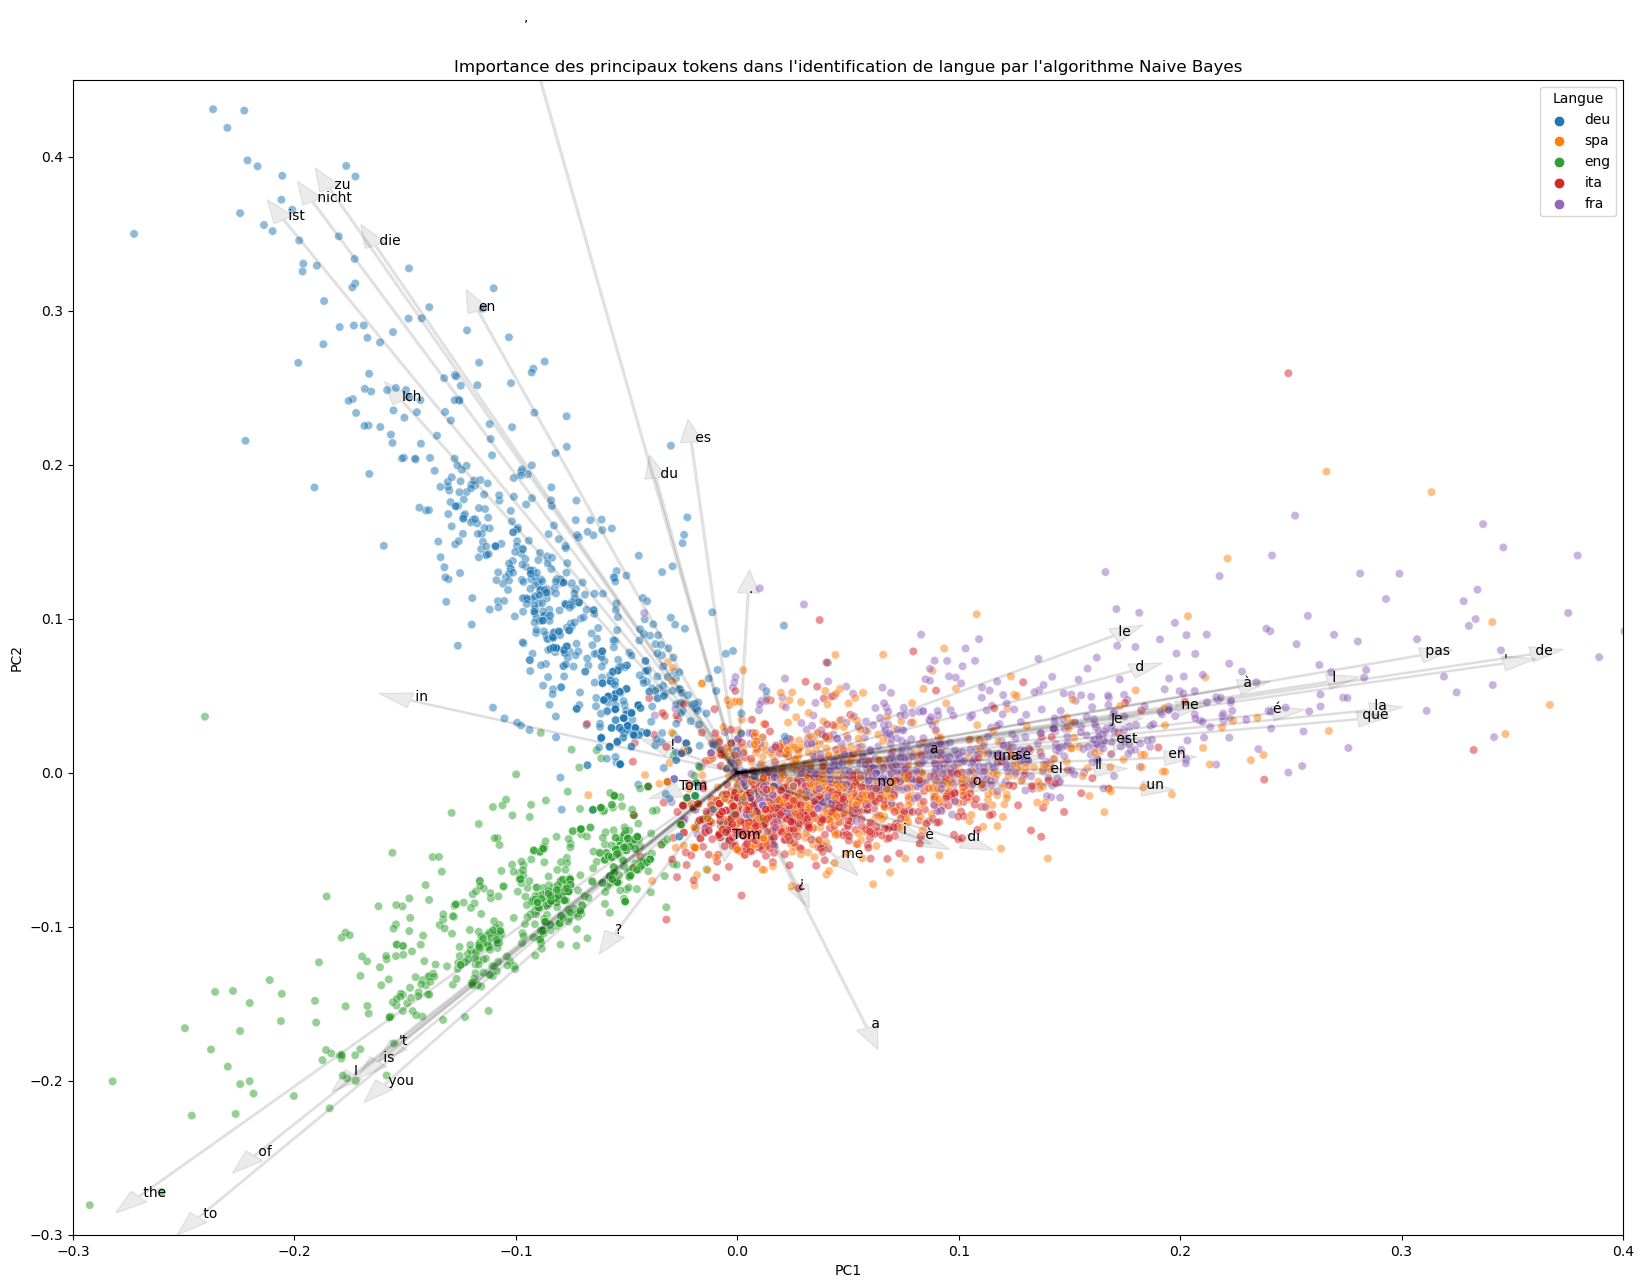

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

max_lines = 5000
max_cols = 100
X = [ligne[:max_cols] for ligne in X_train[:max_lines]]
pd_X_train = pd.DataFrame(data=X, columns = decoded_keys[:max_cols])
# pd_X_train = pd.DataFrame(data=X_train, columns = decoded_keys)

n = pd_X_train.shape[1]

pca = PCA(n_components=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(pd_X_train)

X_new = pca.fit_transform(X_train_scaled)

coeff = pca.components_.transpose()

xs = X_new[:, 0]
ys = X_new[:, 1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())


principalDf = pd.DataFrame({'PC1': xs*scalex, 'PC2': ys * scaley})

y_train_pred = clf_nb.predict(X_train)
finalDF = pd.concat([principalDf, pd.Series(
    y_train_pred, name='Langue')], axis=1)


plt.figure(figsize=(20, 15))

sns.scatterplot(x='PC1', y='PC2', hue='Langue', data=finalDF, alpha=0.5)

for i in range(min(n,50)):
    plt.arrow(0, 0, coeff[i, 0]*1.5, coeff[i, 1]*1.5,
              color='k', alpha=0.08, head_width=0.01, )
    plt.text(coeff[i, 0]*1.5, coeff[i, 1] * 1.5, pd_X_train.columns[i], color='k')

plt.title("Importance des principaux tokens dans l'identification de langue par l'algorithme Naive Bayes") 
plt.xlim(-0.3, 0.4);
plt.ylim(-0.3, 0.45);

### **Algorithme LIME appliqué à une phrase mal classée par Naive Bayes**

In [14]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# Instanciation d'un exemple
exemple = ["Venite dentro. Insisto",
           "I visited Hokkaido during summer vacation.",
           "she loves very luxurious cars, don't you?",
           "vamos a la playa",
           "Ich heiße Keyne, und das ist wunderbar",
           "she loves you, but she te hait aussi, and das ist traurig", # Attention à cette phrase trilingue
           "I ate caviar.",
           "Vogliamo visitare il Colosseo e nuotare nel Tevere.",
          ]

doc_num = 0
# Nous reconstruisons le même modèle mais avec des numpy arrays pour éviter les problème avec LIME du au nomns des features
features = np.array(create_BOW([exemple[doc_num]]))
#print(features)
exp = LimeTabularExplainer(features, feature_names=list(decoded_keys), 
                           class_names=['deu', 'eng','fra','ita','spa'])
print("Phrase :",exemple[doc_num])
print('Predicted Label:',clf_nb.predict(features)[0],' ',clf_nb.predict_proba(features)[0])
exp.explain_instance(features[0], clf_nb.predict_proba, top_labels=6).show_in_notebook()

Phrase : Venite dentro. Insisto
Predicted Label: fra   [0.18836653 0.02916421 0.39393746 0.29862725 0.08990455]


### **Interprétation du processus d'identification d'une langue avec Naïve Bayes**
#### 1- Création d'un BOW Train avec les Token ID en colonne + le lan_code

In [15]:
col_name = [str(key) for key in list(dict_ids.keys())]
df_BOW = pd.DataFrame(data=X_train, columns=col_name)
df_BOW['lan_code']=y_train
display(df_BOW.head())

,13,11,30,264,409,1208,1744,25763,653,279,...,3242,56321,2466,1283,4635,44283,7661,1654,70374,lan_code
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,deu
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spa
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,eng
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ita


#### 2- Calcul du nombre d'apparitions des tokens dans chaque langue
#### 3- Calcul de la probabilité d'apparition de chaque token dans chaque langue 
#### 4- Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7e2c830eac90468e5839385df574ae31d4fc1dbc" style="height:50px">

> où **C** est la classe (*lan_code*), **Fi** est la *caractéristique i* du BOW, **Z** est l'*"evidence"* servant à regulariser la proba 

In [16]:
# Instanciation d'un exemple
exemple = ["Passo a controllare alle otto.",
           "Voilà la mariée !",
           "she loves very luxurious cars, don't you?",
           "vamos a la playa",
           "Ich heiße Keyne, und das ist wunderbar",
           "she loves you, but she te hait aussi, and das ist traurig", # Attention à cette phrase trilingue
           "I ate fruits.",
           "Venite dentro. Insisto",
           "Llévame a casa.",
          ]
lang_exemple = ['ita','fra','eng','spa','deu','eng,fra,deu', 'eng','ita','spa']
                
# Selection de la phrase à analyser
sel_phrase = 8
print("Phrase à analyser :\033[31;46m",lang_exemple[sel_phrase],'- "'+exemple[sel_phrase]+'\033[0m')

# Tokenisation et encodage de la phrase
encodage = tokenizer.encode(exemple[sel_phrase])
print("Nombre de tokens dans la phrase:",len(encodage))

# Création du vecteur BOW de la phrase
bow_exemple = create_BOW([exemple[sel_phrase]])
print("Nombre de tokens retenus dans le BOW:",sum(bow_exemple[0]))
masque_tokens_retenus = [(1 if token in dict_ids else 0) for token in encodage]
print("\033[96;43mTokens retenus\033[0m (se trouvant dans le modèle)     :",end="")
for i in range(len(encodage)):
    if masque_tokens_retenus[i]==1:
        print("\033[96;43m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")
    else: print("\033[31;47m"+tokenizer.decode([encodage[i]])+"\033[0m ",end="")

print("")
# Afin de continuer l'analyse on ne garde que les token de la phrase disponibles dans le BOW
token_used = [str(encodage[i]) for i in range(len(encodage)) if (masque_tokens_retenus[i]==1)]

# Calcul du nombre d'apparition de ces tokens dans le BOW pour chaque langue, et stockage dans un DataFrame df_count
def compter_non_zero(colonne):
    return (colonne != 0).sum()

votes = []
for i in range(len(lan_code)):
    #votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].sum(axis=0)))
    votes.append(list(df_BOW[token_used].loc[df_BOW['lan_code']==lan_code[i]].apply(compter_non_zero)))

col_name = [str(i+1)+'-'+tokenizer.decode([int(token_used[i])]) for i in range(len(token_used))]
df_count = pd.DataFrame(data=votes,columns=token_used, index=lan_code)
df_count.columns = col_name
display(df_count)

# Calcul de la probabilité d'apparition de chaque token dans chaque langue
df_proba = df_count.div(nb_phrases_lang, axis = 0)

# Calcul (par multiplication) de la probabilité d'appartenance de la phrase à une langue
df_proba['Proba'] = 1
# Itérer sur les colonnes et effectuez la multiplication pour chaque ligne
df_proba = df_proba.replace(0.0,0.000001)
for col in df_count.columns:
    df_proba['Proba'] *= df_proba[col]
# Multiplier par la probabilité de la classe
p_classe = [(nb_phrases_lang[i]/df_BOW.shape[0]) for i in range(len(nb_phrases_lang))]
df_proba['Proba'] *= p_classe
# Diviser par l'evidence
evidence = df_proba['Proba'].sum(axis=0)
df_proba['Proba'] *= 1/evidence
df_proba['Proba'] = df_proba['Proba'].round(3)


# Affichage de la matrice des probabilités
display(df_proba)

print("Langue réelle de la phrase                         : ",lang_exemple[sel_phrase])
print("Langue dont la probabilité est la plus forte       : ",df_proba['Proba'].idxmax()," (proba={:.2f}".format(max(df_proba['Proba']))+")")
prediction = clf_nb.predict(bow_exemple) 
print("Langue dont la probabilité prédite par Naiva Bayes : ",prediction[0]," (proba={:.2f}".format(max(clf_nb.predict_proba(create_BOW([exemple[sel_phrase]]))[0]))+")")

Phrase à analyser : spa - "Llévame a casa.
Nombre de tokens dans la phrase: 7
Nombre de tokens retenus dans le BOW: 6
Tokens retenus (se trouvant dans le modèle)     :L lé v ame  a  casa . 


,1-L,2-v,3-ame,4- a,5- casa,6-.
eng,18,3,2,4715,0,24719
fra,582,320,11,2570,0,23104
deu,178,89,26,84,0,23328
spa,178,106,155,4312,444,23753
ita,1492,283,55,2840,368,21767


,1-L,2-v,3-ame,4- a,5- casa,6-.,Proba
eng,0.000646,0.000108,0.000072,0.169239,0.000001,0.887258,0.000
fra,0.020839,0.011458,0.000394,0.092019,0.000001,0.827241,0.000
deu,0.006356,0.003178,0.000928,0.002999,0.000001,0.832964,0.000
spa,0.006360,0.003788,0.005538,0.154077,0.015865,0.848746,0.208
ita,0.052872,0.010029,0.001949,0.100641,0.013041,0.771360,0.792


Langue réelle de la phrase                         :  spa
Langue dont la probabilité est la plus forte       :  ita  (proba=0.79)
Langue dont la probabilité prédite par Naiva Bayes :  ita  (proba=0.81)


> Recherche des phrases mal classées par Naive Bayes

In [17]:
n_bad_max = 30
n_bad = 0
for i in range(len(y_test)):
    if (y_test[i] != y_pred_nb[i]) and (n_bad<n_bad_max):
        n_bad +=1
        print(n_bad,'- No',i,' - Réel:',y_test[i],' Prédit:',y_pred_nb[i],'    ',df_test['sentence'].iloc[i]," (proba={:.2f}".format(max(clf_nb.predict_proba(np.array(create_BOW([df_test['sentence'].iloc[i]])))[0]))+")")


1 - No 97  - Réel: eng  Prédit: ita      Good heavens!  (proba=0.32)
2 - No 114  - Réel: ita  Prédit: deu      Erano entrambe nude.  (proba=0.70)
3 - No 145  - Réel: fra  Prédit: spa      Tu es un opportuniste.  (proba=0.50)
4 - No 166  - Réel: spa  Prédit: fra      Sus calcetines son grises.  (proba=0.54)
5 - No 197  - Réel: spa  Prédit: ita      Llévame a casa.  (proba=0.81)
6 - No 210  - Réel: spa  Prédit: ita      Tom me vio.  (proba=0.51)
7 - No 257  - Réel: fra  Prédit: ita      Le chat attaque un rat.  (proba=0.84)
8 - No 386  - Réel: spa  Prédit: ita      Vi a Tom fumar un cigarrillo.  (proba=0.58)
9 - No 459  - Réel: fra  Prédit: spa      Tu es en premier.  (proba=0.78)
10 - No 633  - Réel: fra  Prédit: spa      Aucun corps.  (proba=0.67)
11 - No 679  - Réel: deu  Prédit: eng      Tom folgte meinem Rat.  (proba=0.45)
12 - No 1015  - Réel: eng  Prédit: deu      Fair, later cloudy.  (proba=0.33)
13 - No 1036  - Réel: ita  Prédit: spa      Devo fermarla.  (proba=0.80)
14 - No 111